# Importing libraries

In [1]:
import numpy as np 
import pandas as pd

# for EDA
import matplotlib.pyplot as plt
import seaborn as sns

# for spliting data and hyperparameter
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate

# preprocessors
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# for model
from sklearn.linear_model import LinearRegression,Ridge
from xgboost import XGBRegressor
from sklearn.svm import SVR

# for pipeline and column_transformer
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import make_pipeline,Pipeline

# for error
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Medical cost personal Dataset
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# EDA


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


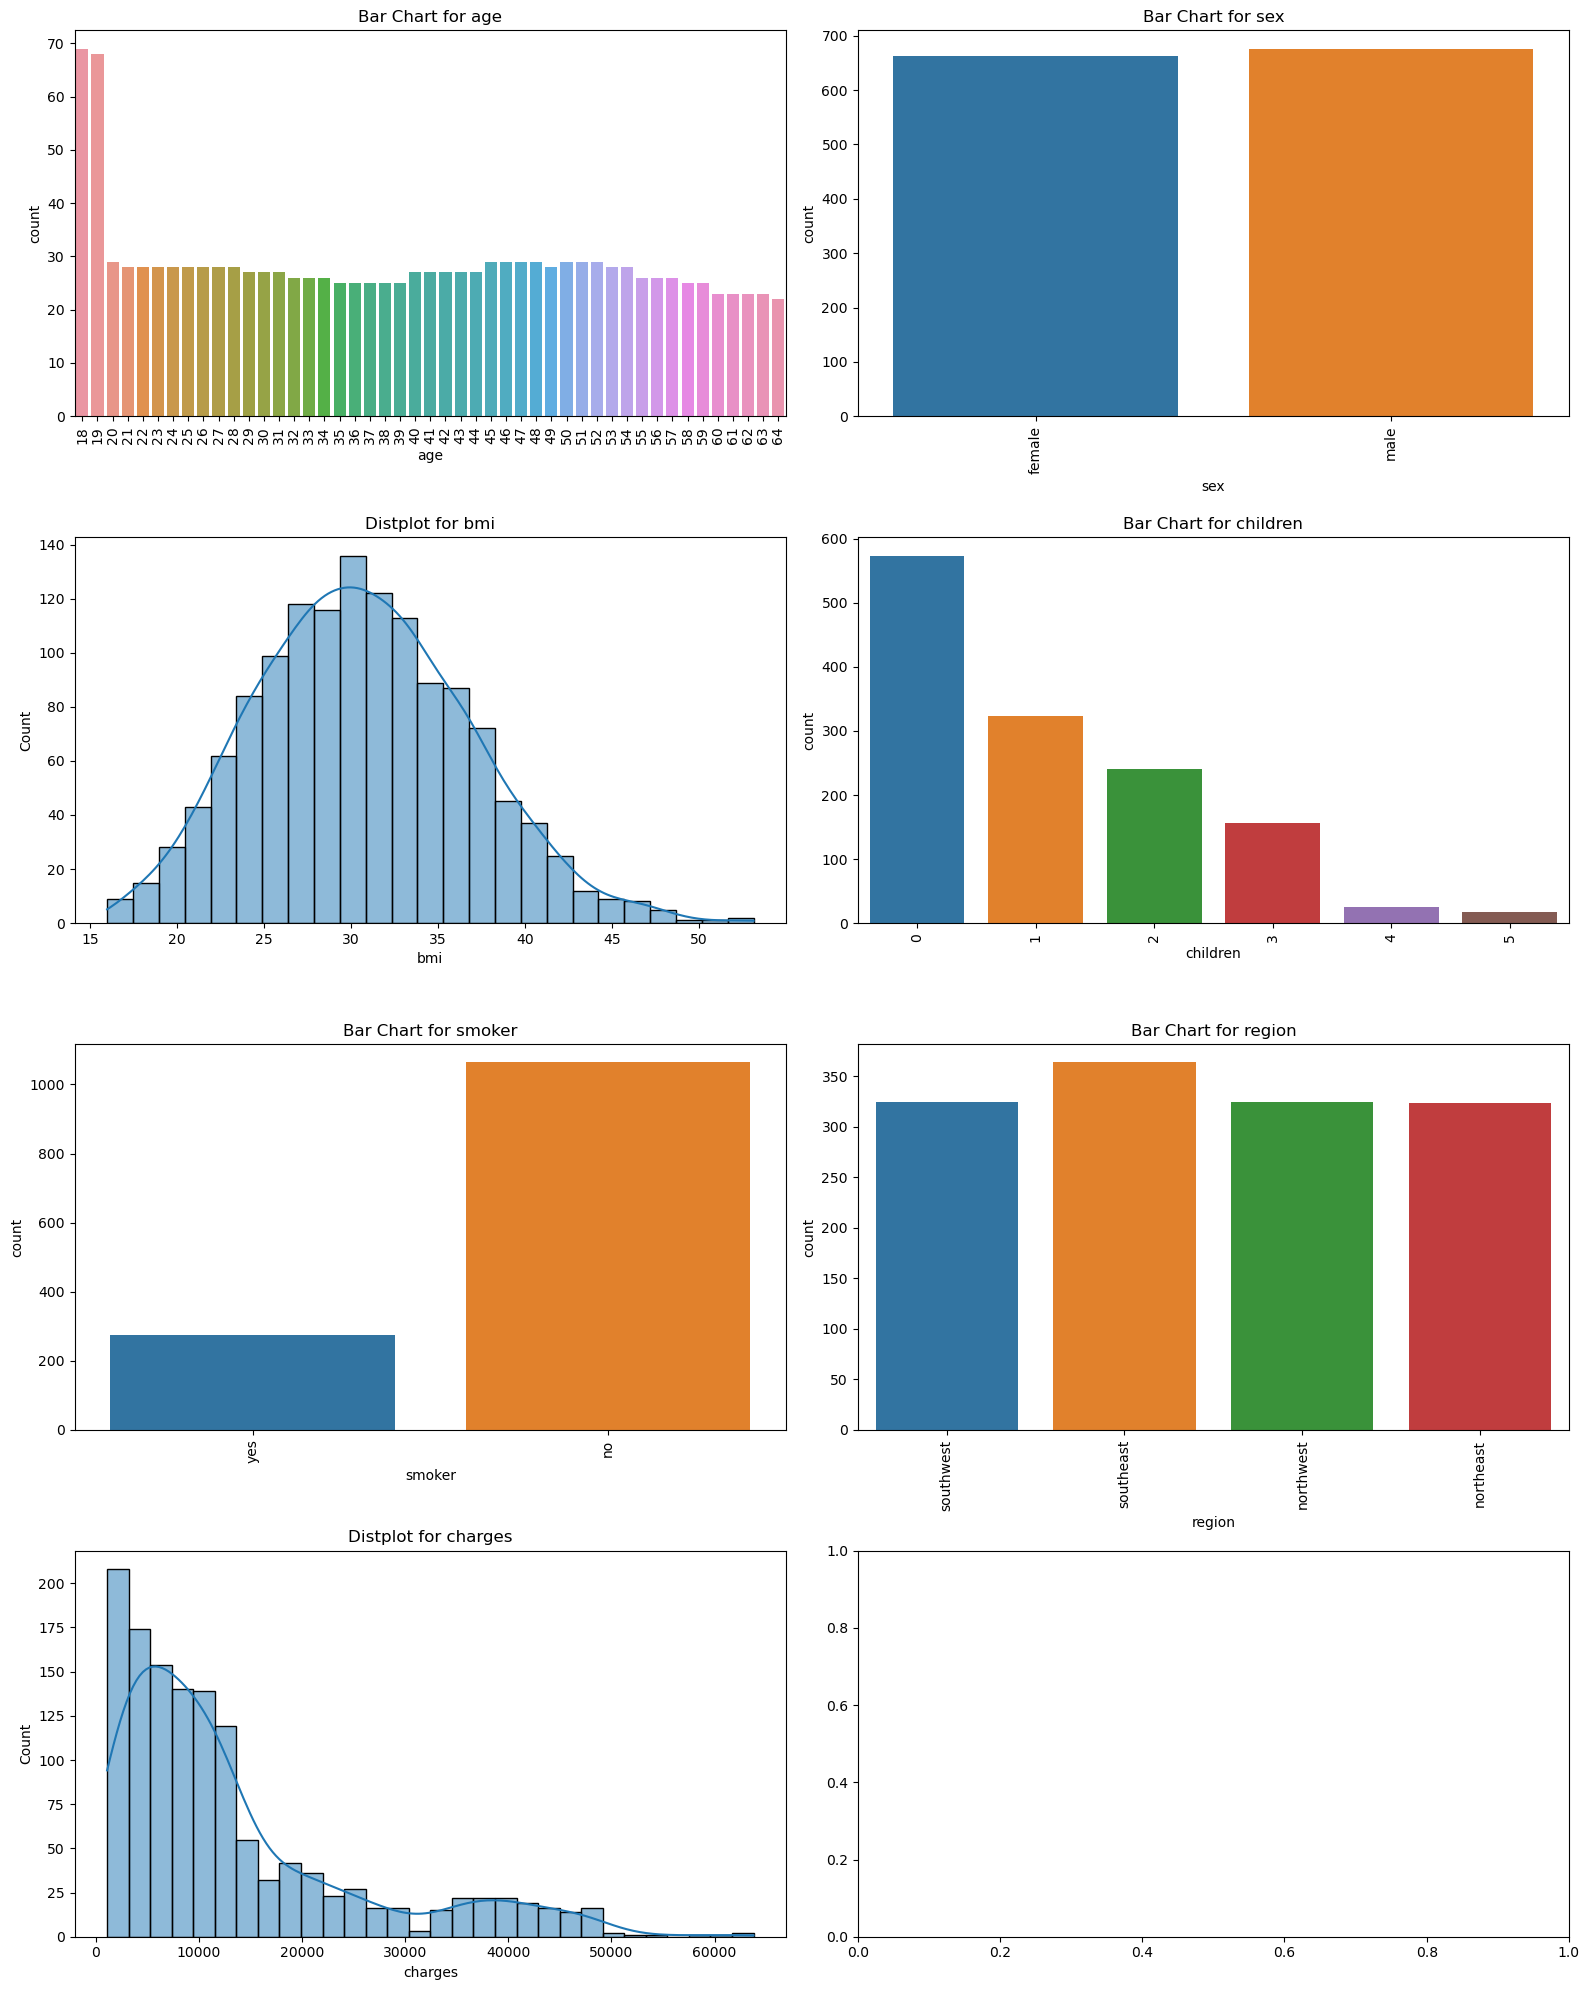

In [4]:
# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create 7 subplots
for i, column in enumerate(data.columns):
    ax = axes[i]
    
    # Check if the column is numerical or categorical
    if data[column].dtype == 'float64':
        # Plot distplot for numerical data
        sns.histplot(data[column], ax=ax, kde=True)
        ax.set_title(f'Distplot for {column}')
    else:
        # Plot bar chart for categorical data
        sns.countplot(x=data[column], ax=ax)
        ax.set_title(f'Bar Chart for {column}')
        ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [5]:
categorical_features = [i for i in data.columns if data[i].dtype != 'float64']
numerical_features = ['bmi']
x,y = data.drop(columns=['charges']),data['charges']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=123)


In [6]:
def error(y_test,y_pred):
    return print(f"mean_absolute_error:-  {mean_absolute_error(y_true=y_test,y_pred=y_pred)},\nmean_absolute_percentage_error:-  {mean_absolute_percentage_error(y_true=y_test,y_pred=y_pred)}")

In [7]:
def error_num(y_test,y_pred):
    MAE = mean_absolute_error(y_true=y_test,y_pred=y_pred)
    MAEP =  mean_absolute_percentage_error(y_true=y_test,y_pred=y_pred)
    Errors = {'MAE':MAE,'MAEP':MAEP}
    return Errors

# using Standardscaler preprocessor on every model  

In [8]:
preprocessor = make_column_transformer((StandardScaler(),numerical_features),
                                       (OneHotEncoder(drop='if_binary'),categorical_features),
                                       remainder='passthrough'
                                      )

# LinearRegression

In [12]:
lr = LinearRegression()
model_lr = make_pipeline(preprocessor,lr)
model_lr.fit(x_train,y_train)
model_lr.score(x_test,y_test)

0.7897103513740523

In [13]:
y_pred_lr = model_lr.predict(x_test)
error(y_test=y_test,y_pred=y_pred_lr)

mean_absolute_error:-  4278.99413311078,
mean_absolute_percentage_error:-  0.45907240189121024


# Ridge

In [14]:
ridge = Ridge(random_state=123)
pipe_ridge = make_pipeline(preprocessor,ridge)
param_grid_ridge = {'ridge__alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000],
                   'ridge__max_iter': [10,15,20,25,30]}
grid_search_ridge = GridSearchCV(pipe_ridge,param_grid=param_grid_ridge,n_jobs=-1,cv=5,return_train_score=True)
grid_search_ridge.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['bmi']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['age',
                                                                          'sex',
                                                                          'children',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('ridge', Ridge(random_state=123))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                          1000],
                         'ridge__max_iter': [10, 15, 20, 25, 30]},
             return_train_score=True)

In [15]:
best_param_ridge = grid_search_ridge.best_params_
best_param_ridge

{'ridge__alpha': 1, 'ridge__max_iter': 10}

In [16]:
ridge = Ridge(alpha=best_param_ridge['ridge__alpha'],max_iter=best_param_ridge['ridge__max_iter'])
model_ridge = make_pipeline(preprocessor,ridge)
model_ridge.fit(x_train,y_train)
model_ridge.score(x_test,y_test)

0.7901386482344928

In [17]:
y_pred_ridge = model_ridge.predict(x_test)
error(y_test=y_test,y_pred=y_pred_ridge)

mean_absolute_error:-  4267.683602113963,
mean_absolute_percentage_error:-  0.46332866508804466


# XGBRegressor

In [122]:
xgbr = XGBRegressor()
model_xgbr = make_pipeline(preprocessor,xgbr)
model_xgbr.fit(x_train,y_train)
model_xgbr.score(x_test,y_test)

0.8472211668619215

In [123]:
y_pred_xgbr = model_xgbr.predict(x_test)
error(y_test=y_test,y_pred=y_pred_xgbr)

mean_absolute_error:-  2774.2710315105237,
mean_absolute_percentage_error:-  0.3281018504569181


# SVR

In [124]:
svr = SVR()
pipe_svr = make_pipeline(preprocessor,svr)
param_grid_svr = {'svr__C': [0.0001,0.001,0.01,0.1,1,10,100,1000],
             'svr__gamma': [0.0001,0.001,0.01,0.1,1,10,100,1000],
            'svr__max_iter': [10,50,100,150,200]}
grid_search_svr = GridSearchCV(pipe_svr,param_grid=param_grid_svr,n_jobs=-1,cv = 5, return_train_score=True)
grid_search_svr.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['bmi']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['age',
                                                                          'sex',
                                                                          'children',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'svr__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                        1000],
                         'svr__max_iter': [10, 50, 100, 150, 200]},
             return_train_score=True)

In [125]:
best_param_svr = grid_search_svr.best_params_
best_param_svr

{'svr__C': 1000, 'svr__gamma': 0.1, 'svr__max_iter': 200}

In [126]:
svr = SVR(C=best_param_svr['svr__C'],gamma=best_param_svr['svr__gamma'],max_iter=best_param_svr['svr__max_iter'])
model_svr = make_pipeline(preprocessor,svr)
model_svr.fit(x_train,y_train)
model_svr.score(x_test,y_test)

0.42475704553639826

In [127]:
y_pred_svr = model_svr.predict(x_test)
error(y_test=y_test,y_pred=y_pred_svr)

mean_absolute_error:-  6053.280800888115,
mean_absolute_percentage_error:-  0.5129968694274627


# using minmaxscaler preprocessor on every model 

In [ ]:
preprocessor1 = preprocessor = make_column_transformer((MinMaxScaler(),numerical_features),
                                       (OneHotEncoder(drop='if_binary'),categorical_features),
                                       remainder='passthrough'
                                      )

# LinearRegression

In [104]:
lr = LinearRegression()
model_lr1 = make_pipeline(preprocessor1,lr)
model_lr1.fit(x_train,y_train)
model_lr1.score(x_test,y_test)

0.7897102824120359

In [105]:
y_pred_lr1 = model_lr1.predict(x_test)
error(y_test=y_test,y_pred=y_pred_lr1)

mean_absolute_error:-  4278.994471305442,
mean_absolute_percentage_error:-  0.4590725893883751


# Ridge

In [106]:
ridge = Ridge(random_state=123)
pipe_ridge1 = make_pipeline(preprocessor1,ridge)
param_grid_ridge1 = {'ridge__alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000],
                   'ridge__max_iter': [10,15,20,25,30]}
grid_search_ridge1 = GridSearchCV(pipe_ridge1,param_grid=param_grid_ridge1,n_jobs=-1,cv=5,return_train_score=True)
grid_search_ridge1.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['bmi']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['age',
                                                                          'sex',
                                                                          'children',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('ridge', Ridge(random_state=123))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                          1000],
                         'ridge__max_iter': [10, 15, 20, 25, 30]},
             return_train_score=True)

In [107]:
best_param_ridge1 = grid_search_ridge1.best_params_
best_param_ridge1

{'ridge__alpha': 1, 'ridge__max_iter': 10}

In [108]:
ridge1 = Ridge(alpha=best_param_ridge['ridge__alpha'],max_iter=best_param_ridge['ridge__max_iter'])
model_ridge1 = make_pipeline(preprocessor,ridge)
model_ridge1.fit(x_train,y_train)
model_ridge1.score(x_test,y_test)

0.7902529195135138

In [109]:
y_pred_ridge1 = model_ridge1.predict(x_test)
error(y_test=y_test,y_pred=y_pred_ridge1)

mean_absolute_error:-  4266.2659808682265,
mean_absolute_percentage_error:-  0.4631563783725418


# XGBRegressor

In [154]:
xgbr = XGBRegressor()
model_xgbr1 = make_pipeline(preprocessor1,xgbr)
model_xgbr1.fit(x_train,y_train)
ans = model_xgbr1.score(x_test,y_test)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(), ['bmi']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['age', 'sex', 'children',
                                                   'smoker', 'region'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              col...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [111]:
y_pred_xgbr1 = model_xgbr1.predict(x_test)
error(y_test=y_test,y_pred=y_pred_xgbr1)

mean_absolute_error:-  2706.1954256122317,
mean_absolute_percentage_error:-  0.34312240684329814


# SVR

In [112]:
svr = SVR()
pipe_svr1 = make_pipeline(preprocessor1,svr)
param_grid_svr1 = {'svr__C': [0.0001,0.001,0.01,0.1,1,10,100,1000],
             'svr__gamma': [0.0001,0.001,0.01,0.1,1,10,100,1000],
            'svr__max_iter': [10,50,100,150,200]}
grid_search_svr1 = GridSearchCV(pipe_svr1,param_grid=param_grid_svr1,n_jobs=-1,cv = 5, return_train_score=True)
grid_search_svr1.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['bmi']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['age',
                                                                          'sex',
                                                                          'children',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'svr__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                        1000],
                         'svr__max_iter': [10, 50, 100, 150, 200]},
             return_train_score=True)

In [113]:
best_param_svr1 = grid_search_svr.best_params_
best_param_svr1

{'svr__C': 1000, 'svr__gamma': 0.1, 'svr__max_iter': 150}

In [114]:
svr = SVR(C=best_param_svr['svr__C'],gamma=best_param_svr['svr__gamma'],max_iter=best_param_svr['svr__max_iter'])
model_svr1 = make_pipeline(preprocessor,svr)
model_svr1.fit(x_train,y_train)
model_svr1.score(x_test,y_test)

0.4972103801953667

In [115]:
y_pred_svr1 = model_svr.predict(x_test)
error(y_test=y_test,y_pred=y_pred_svr1)

mean_absolute_error:-  6329.544362432928,
mean_absolute_percentage_error:-  0.8913014331705411


# Score results on different models with StandardScaler preprocessor

In [136]:
std_model_score = {'Model':['LinearRegression','Ridge','XGBRegressor','SVR'],
                   'Score':[model_lr.score(x_test,y_test),model_ridge.score(x_test,y_test),model_xgbr.score(x_test,y_test),
                            model_svr.score(x_test,y_test)],
                   'MAE':[error_num(y_test=y_test,y_pred=y_pred_lr)['MAE'],error_num(y_test=y_test,y_pred=y_pred_ridge)['MAE'],
                          error_num(y_test=y_test,y_pred=y_pred_xgbr)['MAE'],error_num(y_test=y_test,y_pred=y_pred_svr)['MAE']],
                   'MAEP': [error_num(y_test=y_test,y_pred=y_pred_lr)['MAEP'],error_num(y_test=y_test,y_pred=y_pred_ridge)['MAEP'],
                          error_num(y_test=y_test,y_pred=y_pred_xgbr)['MAEP'],error_num(y_test=y_test,y_pred=y_pred_svr)['MAEP']],
                  }
std_model_results = pd.DataFrame(std_model_score)
std_model_results

,Model,Score,MAE,MAEP
0,LinearRegression,0.789710,4278.994133,0.459072
1,Ridge,0.790139,4267.683602,0.463329
2,XGBRegressor,0.847221,2774.271032,0.328102
3,SVR,0.424757,6053.280801,0.512997


# Score results on different models with MinmaxScaler preprocessor

In [137]:
minmaxscaler_model_score = {'Model':['LinearRegression','Ridge','XGBRegressor','SVR'],
                   'Score':[model_lr1.score(x_test,y_test),model_ridge1.score(x_test,y_test),model_xgbr1.score(x_test,y_test),
                            model_svr1.score(x_test,y_test)],
                   'MAE':[error_num(y_test=y_test,y_pred=y_pred_lr1)['MAE'],error_num(y_test=y_test,y_pred=y_pred_ridge1)['MAE'],
                          error_num(y_test=y_test,y_pred=y_pred_xgbr1)['MAE'],error_num(y_test=y_test,y_pred=y_pred_svr1)['MAE']],
                   'MAEP': [error_num(y_test=y_test,y_pred=y_pred_lr1)['MAEP'],error_num(y_test=y_test,y_pred=y_pred_ridge1)['MAEP'],
                          error_num(y_test=y_test,y_pred=y_pred_xgbr1)['MAEP'],error_num(y_test=y_test,y_pred=y_pred_svr1)['MAEP']],
                  }
std_model_results = pd.DataFrame(minmaxscaler_model_score)
std_model_results

,Model,Score,MAE,MAEP
0,LinearRegression,0.789710,4278.994471,0.459073
1,Ridge,0.790253,4266.265981,0.463156
2,XGBRegressor,0.853379,2706.195426,0.343122
3,SVR,0.497210,6329.544362,0.891301


### our best model is XGBRegressor with minmaxscaler preprocessor, getting 85.33 percent accuracy

<!--  -->

# visualizing model's result

In [223]:
def visualize_model(y_pred,y_train=y_train,y_test=y_test):
    plt.scatter(range(len(y_train)),y=y_train,c='b',label='Training data')
    plt.scatter(range(len(y_test)),y=y_test,c='g',label='Testing data')
    plt.scatter(range(len(y_pred)),y_pred,c='r',label='predicted data')
    plt.legend()
    plt.show()

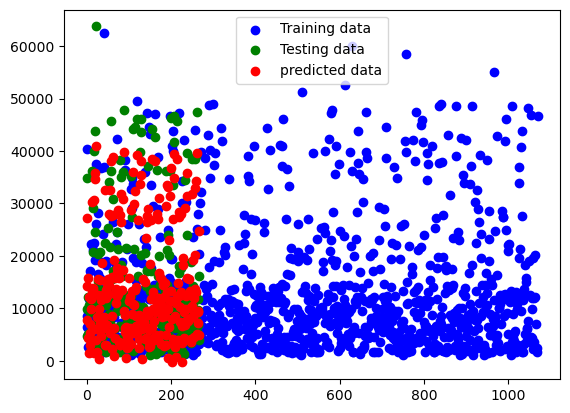

In [224]:
visualize_model(y_pred=y_pred_lr)